In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
train = pd.read_csv('web-traffic-time-series-forecasting/train_1.csv/train_1.csv').fillna(0)

(145063, 551)


In [24]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [25]:
print(train.shape)

(145063, 551)


C:\Users\vv\AppData\Local\Temp\ipykernel_12176\1302643682.py:12: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  plt.tight_layout()
C:\Users\vv\AppData\Local\Temp\ipykernel_12176\1302643682.py:12: UserWarning: Glyph 39791 (\N{CJK UNIFIED IDEOGRAPH-9B6F}) missing from current font.
  plt.tight_layout()
C:\Users\vv\AppData\Local\Temp\ipykernel_12176\1302643682.py:12: UserWarning: Glyph 38307 (\N{CJK UNIFIED IDEOGRAPH-95A3}) missing from current font.
  plt.tight_layout()
C:\Users\vv\AppData\Local\Temp\ipykernel_12176\1302643682.py:12: UserWarning: Glyph 33609 (\N{CJK UNIFIED IDEOGRAPH-8349}) missing from current font.
  plt.tight_layout()
C:\Users\vv\AppData\Local\Temp\ipykernel_12176\1302643682.py:12: UserWarning: Glyph 34905 (\N{CJK UNIFIED IDEOGRAPH-8859}) missing from current font.
  plt.tight_layout()
C:\Users\vv\AppData\Local\Temp\ipykernel_12176\1302643682.py:12: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from current f

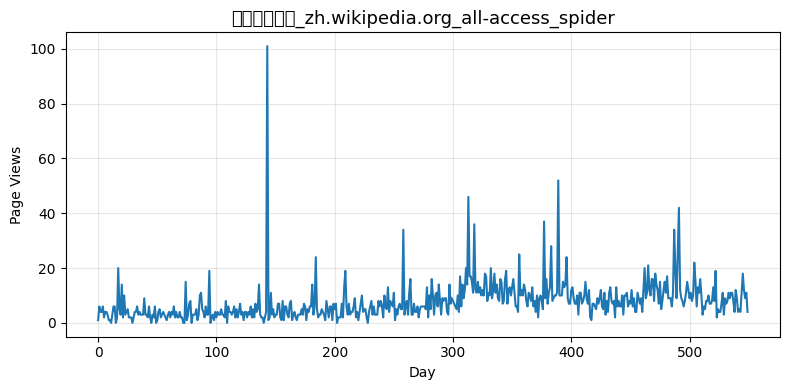

In [20]:

def plot_entry(idx):
    data = train.iloc[idx, 1:]  # Skip the 'Page' column, get all time series data
    page_name = train.iloc[idx, 0]   # Get the page name

    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(data)), data.values, linewidth=1.5)
    plt.title(page_name, fontsize=13)
    plt.xlabel('Day')
    plt.ylabel('Page Views')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_entry(1000)


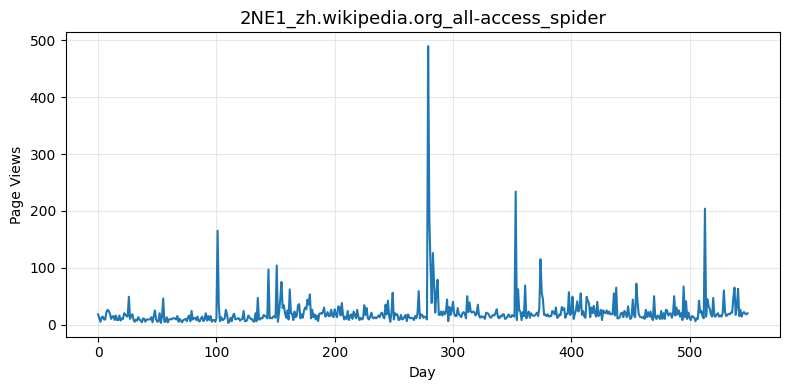

In [21]:
def plot_and_save_entry(idx):
    """
    Plot time series for a given index and save the image to plots folder
    
    Parameters:
    idx (int): Index of the row to plot
    """
    
    # Get the data and page name
    data = train.iloc[idx, 1:]  # Skip the 'Page' column, get all time series data
    page_name = train.iloc[idx, 0]   # Get the page name
    
    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(data)), data.values, linewidth=1.5)
    plt.title(page_name, fontsize=13)
    plt.xlabel('Day')
    plt.ylabel('Page Views')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the plot
    filename = f'plots/plot_{idx}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')

# Example usage:
plot_and_save_entry(0)  # Plot and save the first time series

C:\Users\vv\AppData\Local\Temp\ipykernel_12176\3206488933.py:20: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  plt.tight_layout()
C:\Users\vv\AppData\Local\Temp\ipykernel_12176\3206488933.py:20: UserWarning: Glyph 21513 (\N{CJK UNIFIED IDEOGRAPH-5409}) missing from current font.
  plt.tight_layout()
C:\Users\vv\AppData\Local\Temp\ipykernel_12176\3206488933.py:20: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from current font.
  plt.tight_layout()
C:\Users\vv\AppData\Local\Temp\ipykernel_12176\3206488933.py:24: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\vv\AppData\Local\Temp\ipykernel_12176\3206488933.py:24: UserWarning: Glyph 21513 (\N{CJK UNIFIED IDEOGRAPH-5409}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\vv\AppData\Local\Temp\ipykernel_12176\3206488933.py:24: UserWarning: G

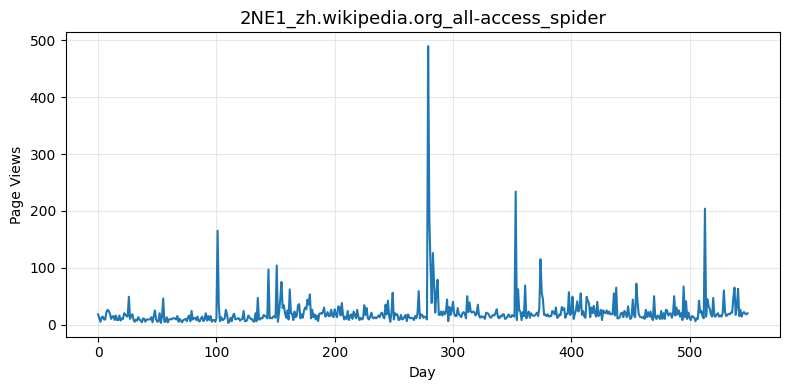

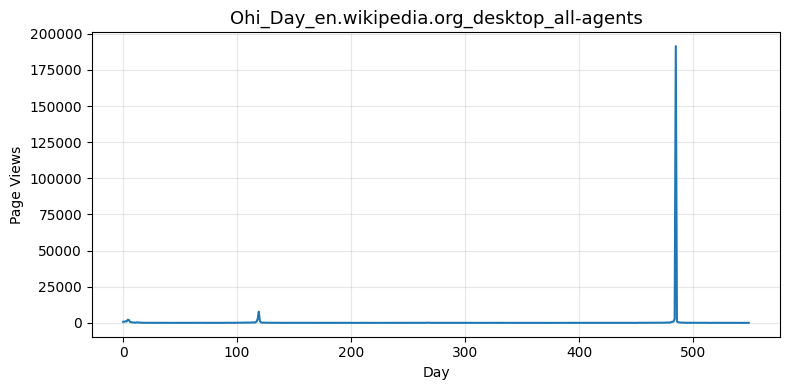

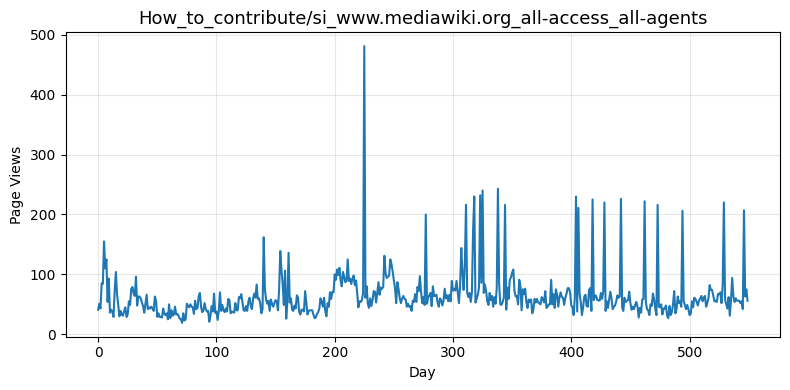

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21513 (\N{CJK UNIFIED IDEOGRAPH-5409}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


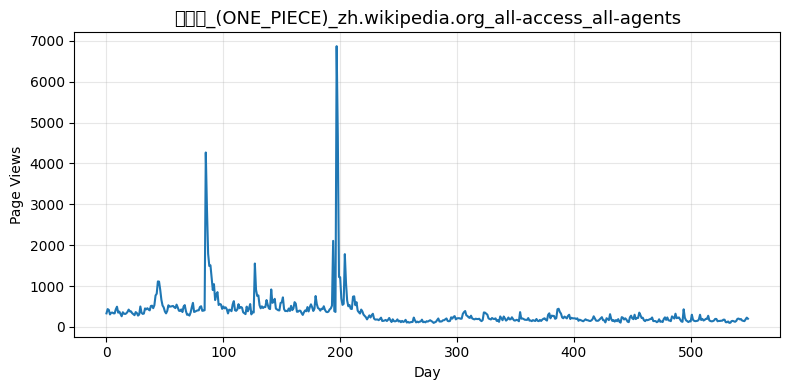

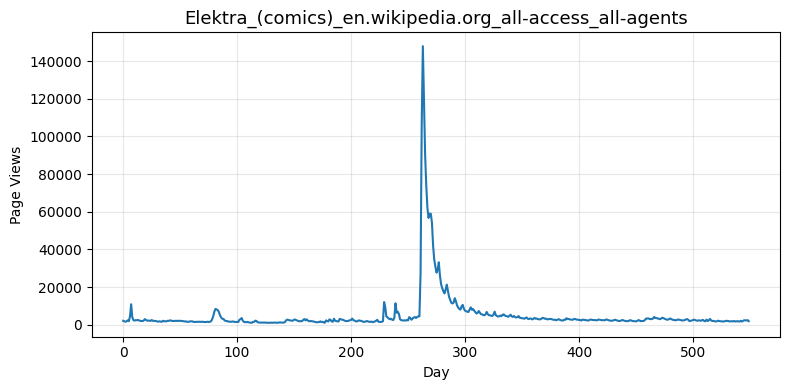

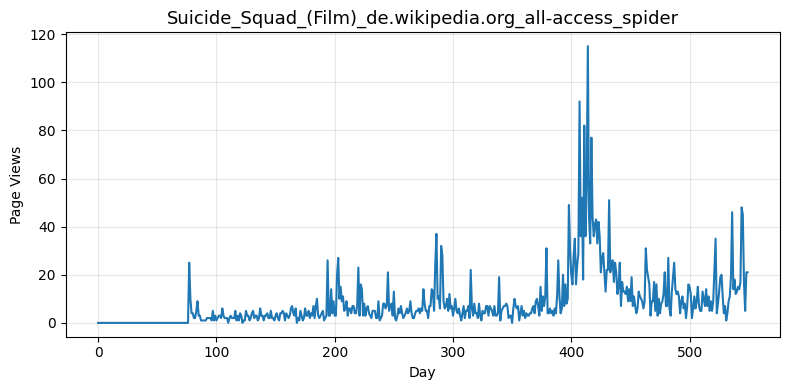

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12418 (\N{HIRAGANA LETTER MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


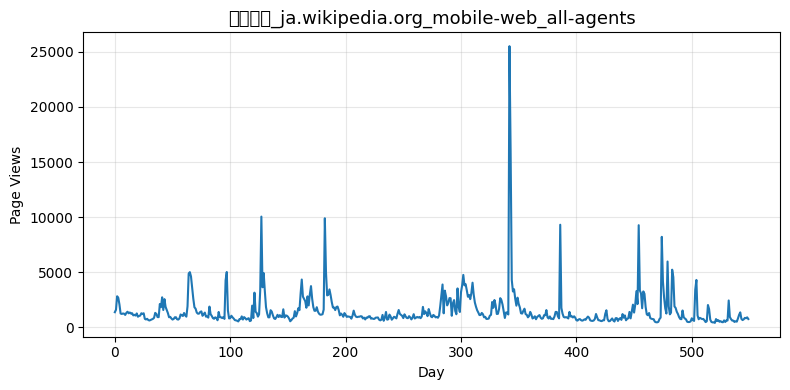

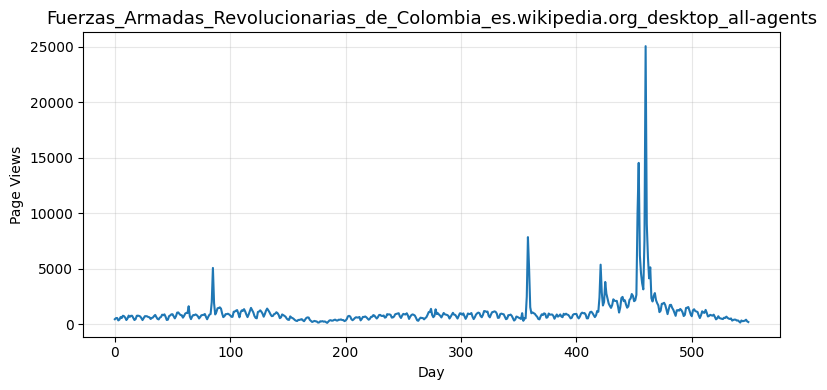

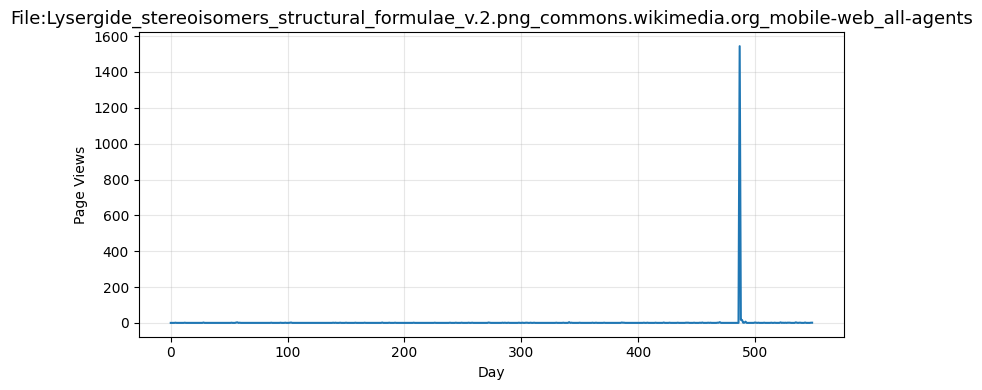

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-ana

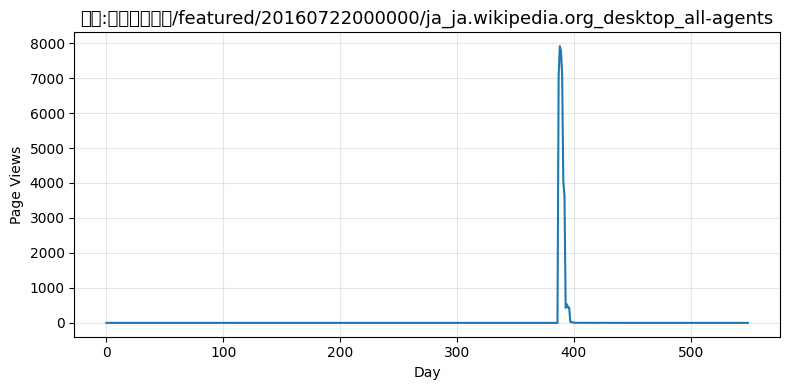

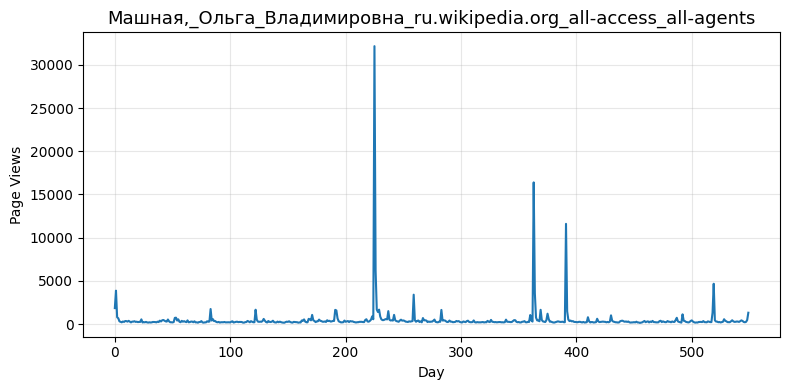

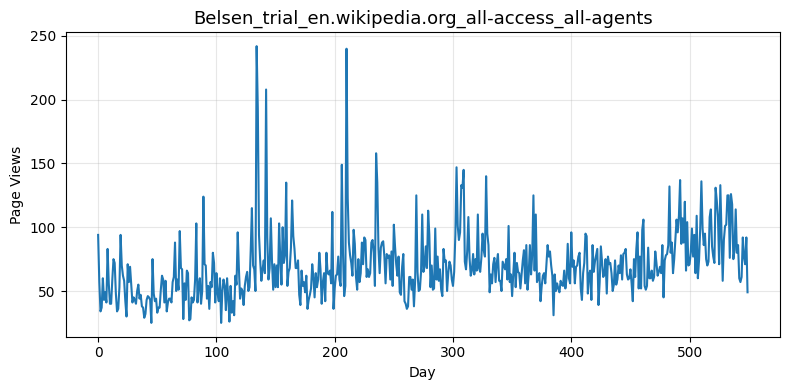

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26519 (\N{CJK UNIFIED IDEOGRAPH-6797}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24736 (\N{CJK UNIFIED IDEOGRAPH-60A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-a

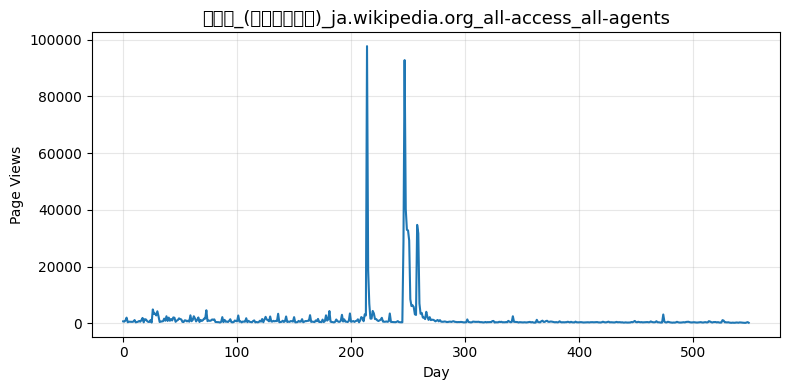

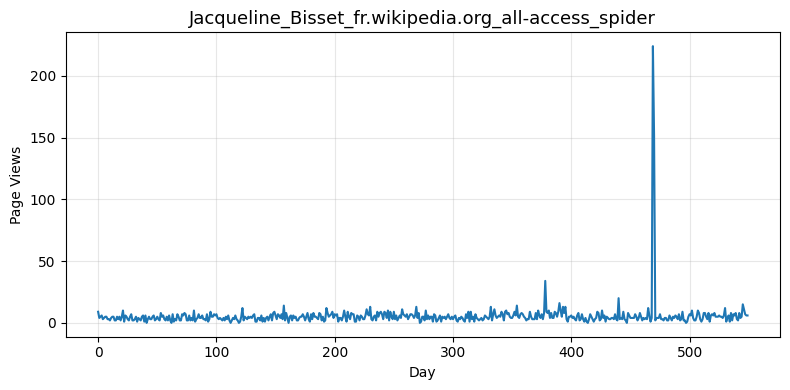

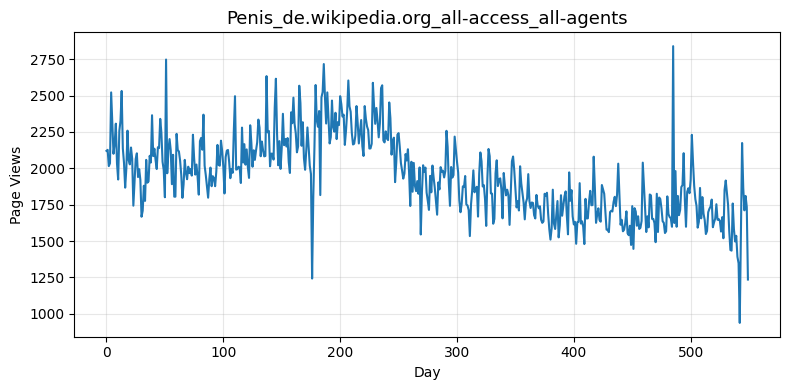

In [23]:
for i in range(0, 15):
    plot_and_save_entry(i*10000) 

In [30]:
def get_date_from_index(day_idx):
    """
    Get the date corresponding to a given column index in the time series data
    
    Parameters:
    day_idx (int): Column index starting from 1
    
    Returns:
    str: Date string from the column header, or None if index is invalid
    """
    if day_idx <= 0 or day_idx >= len(train.columns):
        print(f"Invalid index {day_idx}. Valid range is 1 to {len(train.columns)-1}")
        return None
    

    else:
        # Date columns start from index 1
        date_column = train.columns[day_idx]
        return date_column

# Example usage:
print("Column 1:", get_date_from_index(1))  # First date
print("Column 120:", get_date_from_index(120)) 
print("Column 480:", get_date_from_index(480)) 


Column 1: 2015-07-01
Column 120: 2015-10-28
Column 480: 2016-10-22
